#STL

## Referências


*   **STL Decompose**: https://github.com/jrmontag/STLDecompose/blob/master/STL%20usage%20example.ipynb
* **Explicação sobre Frequência**: https://gist.github.com/balzer82/5cec6ad7adc1b550e7ee

## Setup

Instalação de libraries

In [0]:
!apt-get update

!pip uninstall pandas
!pip install pandas==0.22 # erro que a 23.3 gera: https://stackoverflow.com/questions/50425045/pandas-module-not-found-windows-server-2012/50476916
#!pip install --upgrade pandas==0.23.3
!pip install -U -q PyDrive
!pip install matplotlib
!pip install numpy

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Autenticação Google Drive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autentica e cria um cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Leitura Arquivos de Entrada

Leitura do arquivo .csv pelo ID do arquivo no Drive. Carrega arquivos csv de Treinamento e Teste.

In [0]:
from pandas import read_csv
from pandas import datetime

rawFile = drive.CreateFile({'id': '1-MllP4ibCgh3npxWmNmF3l90LYSWfmyU'})
rawFile.GetContentFile('raw_data.csv')
df = pd.read_csv('raw_data.csv', usecols=['timestamp', 'count'], parse_dates=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.index = df['timestamp'] # seta df['timestamp'] como indice
del df['timestamp']
df.reset_index()
df.head()


df.plot.hist(bins=25)

,count
timestamp,
1980-09-25 14:01:00,182.478
1980-09-25 14:02:00,176.231
1980-09-25 14:03:00,183.917
1980-09-25 14:04:00,177.798
1980-09-25 14:05:00,165.469


In [0]:
df.reset_index()
df.head()

,count
timestamp,
1980-09-25 14:01:00,182.478
1980-09-25 14:02:00,176.231
1980-09-25 14:03:00,183.917
1980-09-25 14:04:00,177.798
1980-09-25 14:05:00,165.469


In [0]:
stl = seasonal_decompose(df, freq=24*60, model='additive')

pandas.core.frame.DataFrame

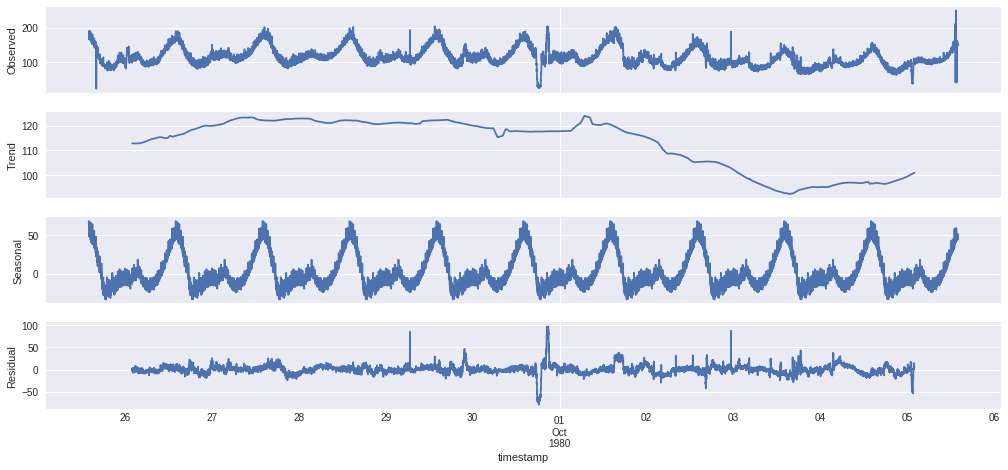

In [0]:
fig = stl.plot()
fig.set_size_inches(15, 7)


residual = stl.resid
seasonal = stl.seasonal
trend = stl.trend

df_resid = pd.concat([residual], axis = 1)
df_resid.columns = ['residual']

df_resid.fillna(0, inplace = True)


In [0]:
median = np.median(df_resid['residual'])
MAD = np.median(abs(df_resid['residual'] - median))
df_resid['Mi'] = 0.6745*(df_resid['residual'] - median) / MAD

In [0]:
df_resid['outlier'] = np.where(((df_resid['Mi']>3.5) | (df_resid['Mi']<-3.5)), df['count'], 0)
df_anom = df_resid[(df_resid['outlier'] != 0)]

3.14%


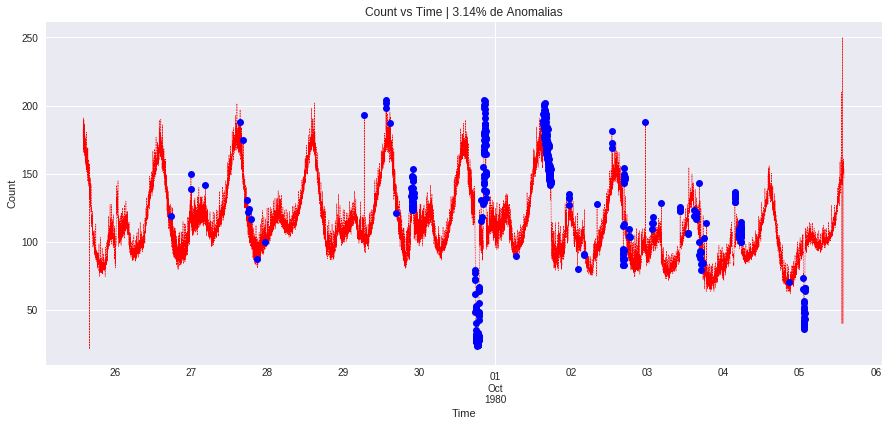

In [0]:
# Calculo share de anomalias
base_count = df.shape[0] # count() nao retorna os NAN
anom_count = df_anom.shape[0]
anom_share = anom_count / base_count
print("{0:.2f}%".format(float(anom_share) * 100)) # share de anomalias

fig, ax = plt.subplots()
df['count'].plot(color = 'red', linestyle='dashed', linewidth = 0.5, x=ax)
df_anom['outlier'].plot(style='bo', ax=ax)

plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count vs Time | '+ str("{0:.2f}%".format(float(anom_share) * 100)) + ' de Anomalias')
plt.subplots_adjust(bottom=0.2)

fig = plt.gcf()
fig.set_size_inches(15, 7)